In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
import torch.distributions as D
import math
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import matplotlib
from typing import Optional

matplotlib.rcParams['animation.writer'] = 'ffmpeg'  # conda install ffmpeg

In [2]:
# https://github.com/rosinality/glow-pytorch/blob/master/model.py

class ZeroLinear(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=True)
        self.linear.weight.data.zero_()
        self.linear.bias.data.zero_()
        self.log_scale = nn.Parameter(torch.zeros(1, out_channels))

    def forward(self, x):
        x = self.linear(x)
        x = x * torch.exp(3 * self.log_scale)

        return x

class AffineCoupling(nn.Module):
    
    def __init__(self, in_channels, hidden_channels: Optional[int] = None, use_sigmoid: bool = False) -> None:
        super().__init__()
        assert in_channels % 2 == 0
        self.use_sigmoid = use_sigmoid
        
        if hidden_channels is None:
            self.net = nn.Linear(in_channels // 2, in_channels, bias=True)
            self.net.weight.data.normal_(0, 0.05)
            self.net.bias.data.zero_()
        else:
            self.net = nn.Sequential(
                nn.Linear(in_channels // 2, hidden_channels, bias=True),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_channels, hidden_channels, bias=True),
                nn.ReLU(inplace=True),
                ZeroLinear(hidden_channels, in_channels),
            )
            self.net[0].weight.data.normal_(0, 0.05)
            self.net[0].bias.data.zero_()
            self.net[2].weight.data.normal_(0, 0.05)
            self.net[2].bias.data.zero_()
        
    def forward(self, x):
        x1, x2 = torch.chunk(x, chunks=2, dim=1)
        log_s, t = torch.chunk(self.net(x1), chunks=2, dim=1)
        if self.use_sigmoid:
            s = torch.sigmoid(log_s + 2)
        else:
            s = torch.exp(log_s)
        y2 = x2 * s + t
        logdet = torch.sum(torch.log(s), dim=1)
        return torch.cat([x1, y2], dim=1), logdet
        
    def reverse(self, y):
        y1, y2 = torch.chunk(y, chunks=2, dim=1)
        log_s, t = torch.chunk(self.net(y1), chunks=2, dim=1)
        if self.use_sigmoid:
            s = torch.sigmoid(log_s + 2)
        else:
            s = torch.exp(log_s)
        x2 = (y2 - t) / s
        return torch.cat([y1, x2], dim=1)

In [3]:
logabs = lambda x: torch.log(torch.abs(x))


class ActNorm(nn.Module):
    
    def __init__(self, in_channels, initialized: bool = True) -> None:
        super().__init__()
        self.s = Parameter(torch.ones(1, in_channels), requires_grad=True)
        self.b = Parameter(torch.zeros(1, in_channels), requires_grad=True)
        self.initialized = initialized
        
    def forward(self, x):
        
        if not self.initialized:
            with torch.no_grad():
                # calculate batch statistics
                mean = x.mean(0, keepdim=True)  # 1 x in_channels
                std = x.std(0, keepdim=True)  # 1 x in_channels
                
                # initialize such that the first batch has zero mean, unit variance 
                self.b.data.copy_(-mean)
                self.s.data.copy_(1 / (std + 1e-6))
                 
        y = self.s * x + self.b
        logdet = torch.sum(logabs(self.s), dim=1)
        return y, logdet
    
    def reverse(self, y):
        x = (y - self.b) / self.s
        return x

In [4]:
class Permute(nn.Module):
    
    def __init__(self, in_channels) -> None:
        super().__init__()
        if in_channels == 2:
            self.forward_indices = torch.tensor([1, 0], dtype=torch.long)
            self.reverse_indices = torch.tensor([1, 0], dtype=torch.long)
            self.logdet = 0.0
        else:
            self.forward_indices = torch.randperm(in_channels)
            self.reverse_indices = torch.argsort(self.forward_indices)
            raise NotImplementedError  # logdet
        
    def forward(self, x):
        y = x[:, self.forward_indices]
        return y, self.logdet
    
    def reverse(self, y):
        x = y[:, self.reverse_indices]
        return x

In [5]:
class FlowBlock(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        self.actnorm = ActNorm(in_channel)
        self.permute = Permute(in_channel)
        self.coupling = AffineCoupling(in_channel, 16, True)

    def forward(self, x):
        x, logdet0 = self.actnorm(x)
        x, logdet1 = self.permute(x)
        x, logdet2 = self.coupling(x)

        logdet = logdet0 + logdet1 + logdet2

        return x, logdet

    def reverse(self, y):
        y = self.coupling.reverse(y)
        y = self.permute.reverse(y)
        y = self.actnorm.reverse(y)

        return y

In [6]:
class Glow(nn.Module):
    # https://arxiv.org/pdf/1807.03039.pdf
    
    def __init__(self, in_channel, num_blocks):
        super().__init__()
        self.flows = nn.ModuleList([FlowBlock(in_channel) for _ in range(num_blocks)])

    def forward(self, x):
        sumlogdet = 0.0
        for flowblock in self.flows:
            x, logdet = flowblock(x)
            sumlogdet = sumlogdet + logdet

        return x, sumlogdet

    def reverse(self, y):
        for flowblock in self.flows[::-1]:
            y = flowblock.reverse(y)
        return y

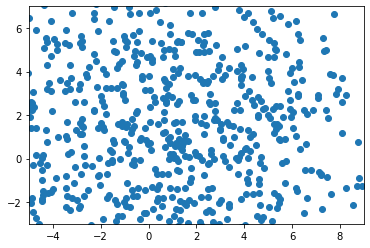

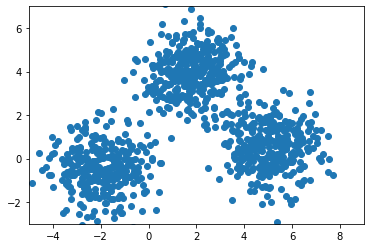

In [7]:
base = D.Normal(torch.zeros(2), 5 * torch.ones(2))
z = base.sample(sample_shape=(1000,))
plt.scatter(*z.T)
plt.gca().set_xlim(-5, 9)
plt.gca().set_ylim(-3, 7)
plt.show()

mix = D.Categorical(torch.ones(3,))
loc = torch.tensor([[5.0, 0.5],[1.8, 3.9],[-2.0, -0.5]])
comp = D.Independent(D.Normal(loc, torch.ones(3,2)), 1)
gmm = D.MixtureSameFamily(mix, comp)

sample = gmm.sample(sample_shape=(1000,))
plt.scatter(*sample.T)
plt.gca().set_xlim(-5, 9)
plt.gca().set_ylim(-3, 7)
plt.show()

Parameters: 10320
c = 9.210340371976182


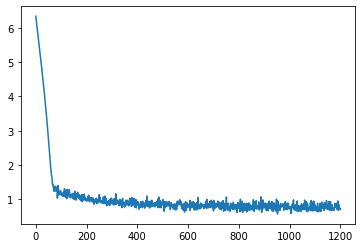

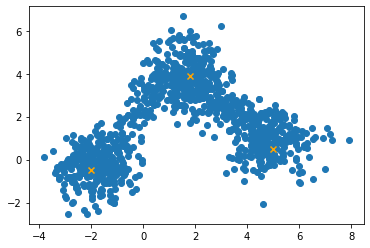

In [8]:
model = Glow(2, 30)
print('Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 128
num_steps = 1200
log_every_nth = 50

a = 0.01
M = 2
uniform = D.Uniform(torch.zeros(2), torch.tensor([a, a]))
c = -M * math.log(a)
print('c =', c)

losses = []
frames = []
for step in range(num_steps):
    x = gmm.sample(sample_shape=(batch_size,))
    # u = uniform.sample(sample_shape=(batch_size,))
    
    z, sumlogdet = model(x) # + u)
    
    optimizer.zero_grad(set_to_none=True)
    loss = -(base.log_prob(z) + sumlogdet[:, None]).mean() # + c
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    
    if step % log_every_nth == 0:
        with torch.no_grad():
            z = base.sample(sample_shape=(1000,))
            x = model.reverse(z)
            frames.append(x)

plt.plot(losses)
plt.show()

with torch.no_grad():
    z = base.sample(sample_shape=(1000,))
    x = model.reverse(z)
    plt.scatter(*x.detach().numpy().T)
    plt.scatter(*loc.T, marker='x', c='orange')
    plt.show()

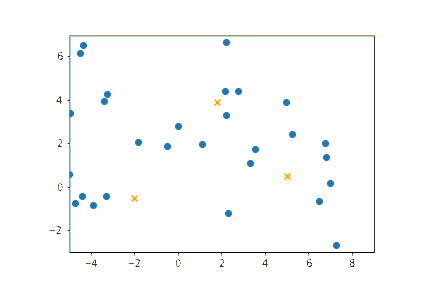

In [9]:
def AnimationFunction(frame):
    ax = plt.gca()
    ax.clear()
    ax.set_xlim(-5, 9)
    ax.set_ylim(-3, 7)
    ax.set_aspect ('equal')
    ax.scatter(*frame.detach().numpy().T)
    ax.scatter(*loc.T, marker='x', c='orange')


anim = FuncAnimation(plt.gcf(), AnimationFunction, frames=frames, interval=250)
anim.save('animation.gif')
plt.close()
Image(filename='animation.gif')